In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_timeline(t_max, dt):
    return np.arange(0, t_max, dt)

# 1. Hodgkin-Huxley model of action potential generation.

In [3]:
def initialize_arrays(t,initial_values) :
    n = np.zeros(len(t))
    m = np.zeros(len(t))
    h = np.zeros(len(t))
    i_k = np.zeros(len(t))
    i_na = np.zeros(len(t))
    i_leak = np.zeros(len(t))
    v = np.zeros(len(t))
    
    n[0] = initial_values['n0']
    m[0] = initial_values['m0']
    h[0] = initial_values['h0']
    v[0] = initial_values['v0']

    return n, m, h, i_k, i_na, i_leak, v

In [4]:
def euler(f_func, t_max, dt, params, initial_values):
    t = get_timeline(t_max, dt)
    
    n, m, h, i_k, i_na, i_leak, v = initialize_arrays(t, initial_values)
    
    i_e = exp_applied_current(params, t)
    
    for i in range(len(t)-1):
        n[i+1] = n[i] + open_close_ion_channel_probability(alpha_n, beta_n, v[i], n[i])*dt
        m[i+1] = m[i] + open_close_ion_channel_probability(alpha_m, beta_m, v[i], m[i])*dt
        h[i+1] = h[i] + open_close_ion_channel_probability(alpha_h, beta_h, v[i], h[i])*dt
        
        i_k[i+1] = potassium_current(v[i], n[i])
        i_na[i+1] = sodium_current(v[i], m[i], h[i])
        i_leak[i+1] = leak_current(v[i]) 
        
        v[i+1] = v[i] + f_func(v[i], i_k[i+1], i_na[i+1], i_leak[i+1], i_e[i], params['c_m'])*dt
    return n, m, h, i_k, i_na, i_leak, v, t

In [5]:
def alpha_n(v) :
    return 0.01*(v + 55)/(1 - np.exp(-0.1 * (v + 55)))

In [6]:
def beta_n(v) :
    return 0.125 * np.exp(-0.0125 * (v + 65))

In [7]:
def alpha_m(v) :
    return 0.1*(v + 40)/(1 - np.exp(-0.1 * (v + 40)))

In [8]:
def beta_m(v) :
    return 4 * np.exp(-0.0556 * (v + 65))

In [9]:
def alpha_h(v) :
    return 0.07 * np.exp(-0.05 * (v + 65))

In [10]:
def beta_h(v) :
    return 1/(1 + np.exp(-0.1 * (v + 35)))

In [11]:
def open_close_ion_channel_probability(alpha_func, beta_func, v, x) :
    return alpha_func(v)*(1-x) - beta_func(v)*x

In [12]:
def open_close_ion_channel_probability_m(m, t, params) :
    return alpha_m(params['v'])*(1-m) - beta_m(params['v'])*m

In [13]:
def open_close_ion_channel_probability_h(h, t, params) :
    return alpha_h(params['v'])*(1-h) - beta_h(params['v'])*h

In [14]:
# 1 Seimens = 1 Ampere/Volt = 1/1000 A/mV
# in our problem, voltages is in mV, thus if we use conductance in Seimens, the current will be in (10^-3)A

In [15]:
def potassium_current(v, n) :
    g_k = 36 * 1e-9 #S
    e_k = -77  #mV
    return g_k * np.power(n,4) * (v - e_k) * 1e-3 # current in A

In [16]:
def sodium_current(v, m, h) :
    g_na = 120*1e-9 #S
    e_na = 50 #mV
    return g_na * np.power(m,3) * h * (v - e_na) * 1e-3 # current in A

In [17]:
def leak_current(v) :
    g_leak = 0.3 * 1e-9 #S
    e_leak =-54.387 #mV
    return g_leak * (v - e_leak) * 1e-3 # current in A

In [18]:
def exp_applied_current(params, t) :

    i_e = np.zeros(len(t))
    if params['is_Ie_time_dep'] : 
        for i in range(len(t)) :
            if(t[i] <= params['current_pulse_length']) :
                i_e[i] = params['ie']
    elif params['is_Ie_sinusoidal'] :
        i_e = (2*1e-12) * np.sin(2 * np.pi * params['freq'] * (t * 1e-3)) # time in seconds
    else:
        i_e.fill(params['ie'])
        
    return i_e

### 1 (a) Simulate the Hodgkin-Huxley model by numerically

In [19]:
def hodgkin_huxley_model(v, i_k, i_na, i_leak, i_e, c_m) :
    i = (- i_na - i_k - i_leak + i_e)*1e-9 # in nA
    c_m = c_m*1e-12
    potential = (- i_na - i_k - i_leak + i_e)/c_m # in volt/sec = mV/ms
    return potential # in mV/ms

In [20]:
dt = 1e-2 # in ms
t_max = 50 #(in ms) as per the sample graph

initial_values = {
    'v0' : -65,
    'n0' : 0.3177,
    'm0' : 0.0529,
    'h0' : 0.5961
}

params = {
    'ie' : 0,
    'is_Ie_time_dep' :  False,
    'is_Ie_sinusoidal' : False,
    'current_pulse_length' : 0,
    'c_m' : 1
}

n, m, h, i_k, i_na, i_leak, v_1a, t = euler(hodgkin_huxley_model, t_max, dt, params, initial_values);

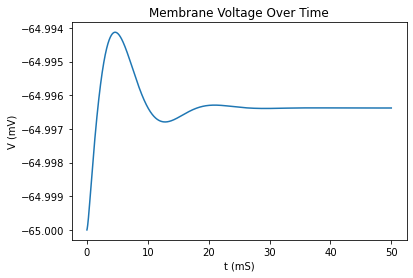

In [21]:
ax = plt.gca()
ax.ticklabel_format(useOffset=False)

plt.title('Membrane Voltage Over Time')
plt.plot(t,v_1a)
plt.xlabel('t (mS)')
plt.ylabel('V (mV)');

**Discussion** : A damped oscillation with a very small amplitude is vissible as expected.

### 2 (b) Apply now a constant external current Ie = 20 pA

In [22]:
params['ie'] = 20*1e-12

n, m, h, i_k, i_na, i_leak, v_1a, t = euler(hodgkin_huxley_model, t_max, dt, params, initial_values)

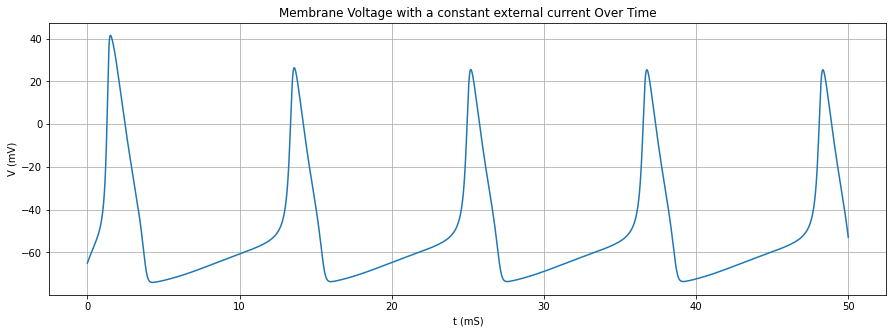

In [23]:
plt.figure(figsize=(15,5))

ax = plt.gca()
ax.ticklabel_format(useOffset=False)

plt.title('Membrane Voltage with a constant external current Over Time')
plt.plot(t,v_1a)
plt.xlabel('t (mS)')
plt.ylabel('V (mV)')
plt.grid();

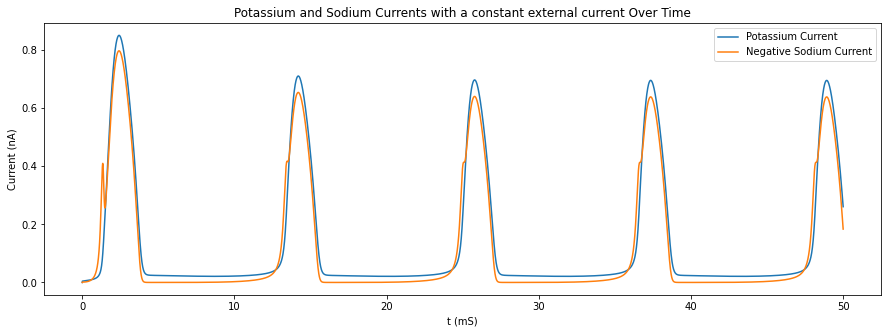

In [24]:
plt.figure(figsize=(15,5))

ax = plt.gca()
ax.ticklabel_format(useOffset=False)

plt.title('Potassium and Sodium Currents with a constant external current Over Time')
plt.plot(t,i_k*1e9, label='Potassium Current')
plt.plot(t,-i_na*1e9, label='Negative Sodium Current')
plt.xlabel('t (mS)')
plt.ylabel('Current (nA)')
plt.legend();

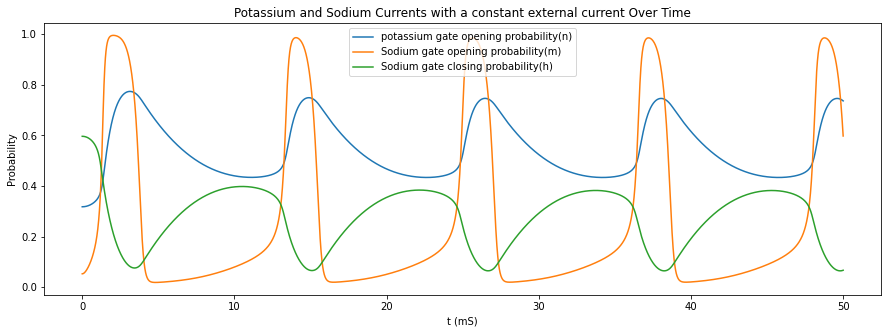

In [37]:
plt.figure(figsize=(15,5))

ax = plt.gca()
ax.ticklabel_format(useOffset=False)

plt.title('Potassium and Sodium Currents with a constant external current Over Time')
plt.plot(t, n, label='potassium gate opening probability(n)')
plt.plot(t, m, label='Sodium gate opening probability(m)')
plt.plot(t, h, label='Sodium gate closing probability(h)')
plt.xlabel('t (mS)')
plt.ylabel('Probability')
plt.legend();

**Discussion:** 
- With an external current the the membrane voltage increases to reach above the threshold voltage
- The Sodium gate opening probability increases rapidly and closing probability decreases slowly, resulting in the rapid increase in Sodium current (current flowing inside the neuron) resulting in **Depolarization**. Along with this the Potassium gate probabilty increases very slowly
- When the voltage reaches the maximum voltage that results in sudden decrease of the Sodium opening probability and increase in Sodium gate closing probability. At the same time, the potassium gate probability increases. Resulting in **Repolarization**.
- The Potassium gate takes a longer time to close thus reulting in a **Hyperpolation**
- The slow opening of the sodim gate then slowly moves back the membrane voltage to rest


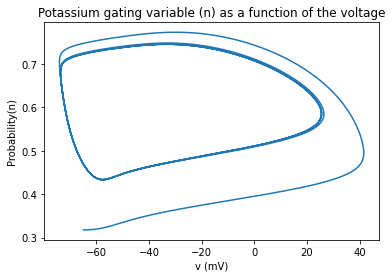

In [26]:
plt.title('Potassium gating variable (n) as a function of the voltage')
plt.plot(v_1a, n)
plt.xlabel('v (mV)')
plt.ylabel('Probability(n)');

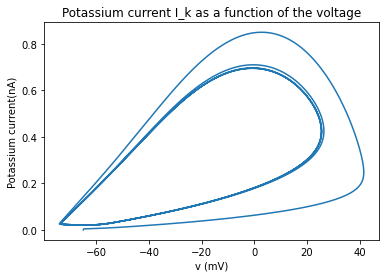

In [27]:
plt.title('Potassium current I_k as a function of the voltage')
plt.plot(v_1a, i_k*1e9)
plt.xlabel('v (mV)')
plt.ylabel('Potassium current(nA)');

**Discussion:** 
 Initially, the ligher shade plot shows that the potassium probabilty and current increases. But when it reaches the maximum voltage, the probabilty and current values increases and goes in a loop as the voltage again drecreases back.
 The hyperpolarization impact are also clearly visible.

### 1 (c) Plot the firing rate of the model as a function of Ie over the range from 0 to 20 pA.

In [28]:
def get_firing_rate(v, dt):
    spike_indices = np.zeros(20)
    v_thresh = -54 # mV
    spike_count = 0
    for i in range(len(v)-1):
        if(v[i] < v_thresh and v[i+1] >= v_thresh) :
            spike_indices[spike_count] = (i+1) * (dt * 1e-3)
            spike_count+=1
    
    if spike_count < 2: 
        return 0
#     elif spike_count == 1:
#         print(t_max)
#         return 1e3/(t_max)
    else:
        isi = spike_indices[1] - spike_indices[0] 
        return 1/isi

max(firing_rates) = 86.58008658008659


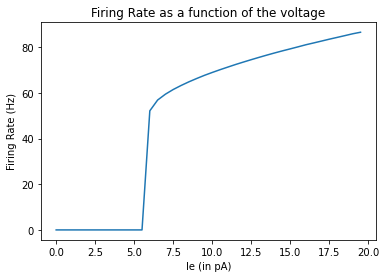

In [29]:
i_e_range = np.arange(0, 20, 0.5) #in pA
firing_rates = np.zeros(len(i_e_range))
# voltage_range = np.zeros(len(i_e_range))


for i in range(len(i_e_range)) :
    params['ie'] = i_e_range[i]*1e-12
    _, _, _, _, _, _, v1c, _ = euler(hodgkin_huxley_model, t_max, dt, params, initial_values)
    firing_rates[i] = get_firing_rate(v1c, dt, )
    
plt.title('Firing Rate as a function of the voltage')
plt.plot(i_e_range, firing_rates)
plt.xlabel('Ie (in pA)')
plt.ylabel('Firing Rate (Hz)');

print(f'{max(firing_rates) = }')

**Discussion:** 
- For **integrate and fire model :** The Firing rate gradually increases from 0 to max
- For **Hodgkin and Huxley Model :** The firing rate hava sudden jump from 0 to a certain value and then increases gradually

### 1 (d) Apply a negative current pulse of Ie = -5 pA for 5 ms followed by Ie = 0 pA and see what happens.

In [30]:
params['ie'] = -5*1e-12
params['is_Ie_time_dep'] = True
params['current_pulse_length'] = 5


n_1d, m_1d, h_1d, i_k_1d, i_na_1d, _, v_1d, t_1d = euler(hodgkin_huxley_model, t_max, dt, params, initial_values)

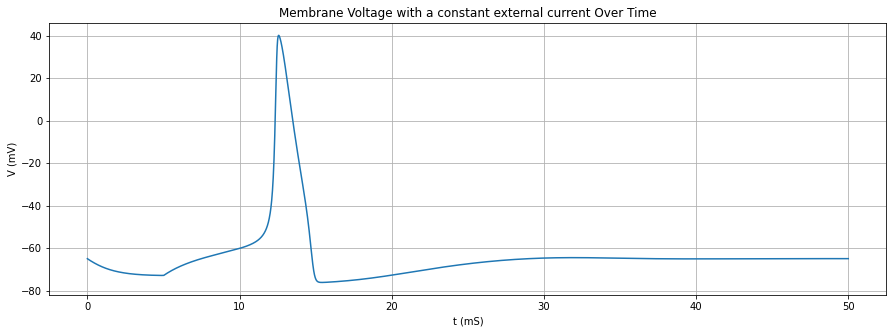

In [31]:
plt.figure(figsize=(15,5))

ax = plt.gca()
ax.ticklabel_format(useOffset=False)

plt.title('Membrane Voltage with a constant external current Over Time')
plt.plot(t_1d,v_1d)
plt.xlabel('t (mS)')
plt.ylabel('V (mV)')
plt.grid();

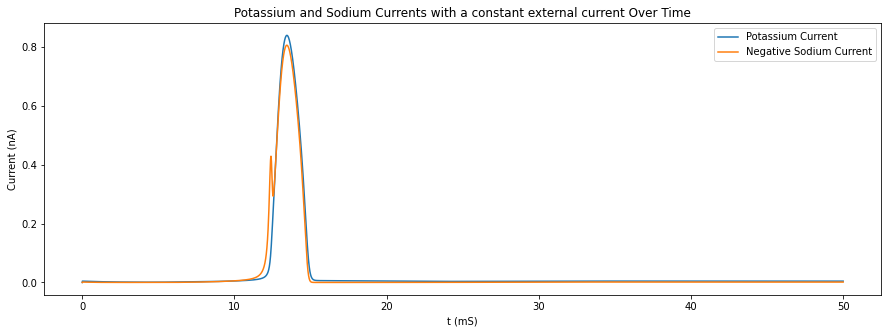

In [32]:
plt.figure(figsize=(15,5))

ax = plt.gca()
ax.ticklabel_format(useOffset=False)

plt.title('Potassium and Sodium Currents with a constant external current Over Time')
plt.plot(t_1d,i_k_1d*1e9, label='Potassium Current')
plt.plot(t_1d,-i_na_1d*1e9, label='Negative Sodium Current')
plt.xlabel('t (mS)')
plt.ylabel('Current (nA)')
plt.legend();

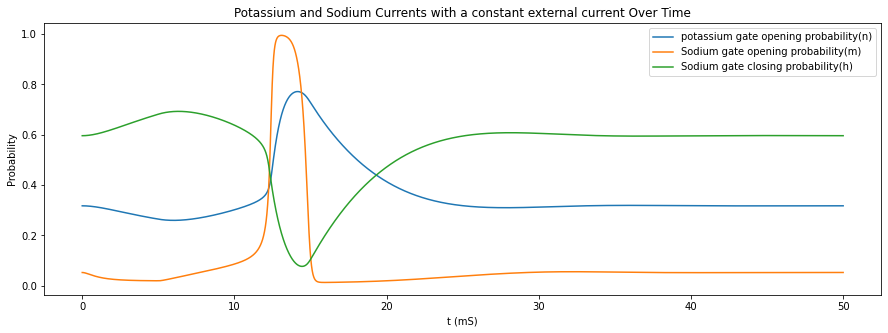

In [33]:
plt.figure(figsize=(15,5))

ax = plt.gca()
ax.ticklabel_format(useOffset=False)

plt.title('Potassium and Sodium Currents with a constant external current Over Time')
plt.plot(t_1d, n_1d, label='potassium gate opening probability(n)')
plt.plot(t_1d, m_1d, label='Sodium gate opening probability(m)')
plt.plot(t_1d, h_1d, label='Sodium gate closing probability(h)')
plt.xlabel('t (mS)')
plt.ylabel('Probability')
plt.legend();

**Discussion :** 
- Even if the external current is negetive, due to sudden change in current the voltage increases resulting in an action potential

### 1 (e) (bonus) Drive your Hodgkin-Huxley neuron with an external sinusoidal current Ie = I0 sin(2$\pi$$\nu$t) with I0 = 2 pA.

In [34]:
def get_time_max(freq, dt, no_of_osci):
    
    time_prd_1_osci = 1/freq
#     divisions_per_osci = int(time_prd_1_osci/dt)
    t_max = (time_prd_1_osci) * no_of_osci 
    
#     return time_prd_1_osci, divisions_per_osci, t_max
    return t_max

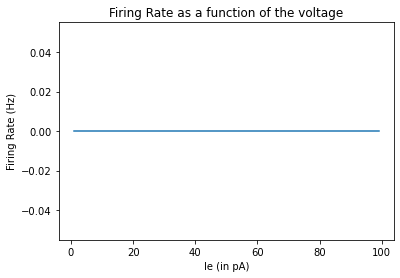

In [35]:
params['is_Ie_time_dep'] = False
params['is_Ie_sinusoidal'] = True

freq_range = np.arange(1, 100, 1)
firing_rates_1e = np.zeros(len(freq_range))

for i in range(len(freq_range)) :
    t_max = get_time_max(freq_range[i], dt, 20) # lets consider time period for 20 oscillation
    params['freq'] = freq_range[i]
    n_1e, m_1e, h_1e, i_k_1e, i_na_1e, _, v_1e, t_1e = euler(hodgkin_huxley_model, t_max, dt, params, initial_values)
    firing_rates_1e[i] = get_firing_rate(v_1e, dt)
    
plt.title('Firing Rate as a function of the voltage')
plt.plot(freq_range, firing_rates_1e)
plt.xlabel('Ie (in pA)')
plt.ylabel('Firing Rate (Hz)');

# print(f'{max(firing_rates) = }')